 Classification

## Task 1: Logistic Regression on Bank Data

#### Bank client data:

1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

#### Related with the last contact of the current campaign:

9. contact: contact communication type (categorical: "unknown","telephone","cellular")
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

#### Other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

#### Output variable (desired target):
17. y - has the client subscribed a term deposit? (binary: "yes","no")


Run this cell by default to load the dataset.

In [1]:
import pandas as pd

data = pd.read_csv("bank-full.csv", encoding='utf-8', delimiter=";")

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Task1A: 
1. Is there any need to convert columns based on their Dtype? Check details about the data.
2. Check if there are any missing values. Handle the missing values if any.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#Comment your Actions if any

### Task 1B: 
First things first!
Before applying feature engineering or bringing the columns to appropriate form, split the data into training/testing.
Why? because by doing this we ensure that there is no data leakage.

1. Map the target variable.
2. Split the data into training/testing with 80-20 ratio.
3. Use stratify since to ensure equal percentage of class samples into both subsamples.

In [4]:
target = {'no': 0, 'yes': 1}
data['y'] = data['y'].map(target)

In [5]:
from sklearn.model_selection import train_test_split
input = data.drop(columns=['y'])
output = data['y']
input_train, input_test, output_train, output_test = train_test_split(input, output, test_size=0.2, random_state=42, stratify=output)


### Task 1C: 
Define a class 'convert_cat' which will-

1. Map the binary categorical values.
2. Is it fleasible to create dummy variables from 'month' categircal variable? My suggestion use frequency encoding.
3. Create dummy variables for the rest of the categorical variables.

Note: be very careful to handle each column while converting them.

In [6]:
import pandas as pd

class ConvertCat:
    def __init__(self):
        self.binary_mapping = None
        self.month_freq_mapping = None
        self.categorical_columns = None

    def fit(self, data1):
        self.binary_mapping = {}
        self.month_freq_mapping = {}
        self.categorical_columns = data.select_dtypes(include='object').columns.tolist()
        converted_categorical_cols = []
        for col in self.categorical_columns:
            unique_values = data1[col].unique()
            if len(unique_values) == 2:
                mapping = {val: idx for idx, val in enumerate(unique_values)}
                self.binary_mapping[col] = mapping
                converted_categorical_cols.append(col)
        month_freq = data1['month'].value_counts(normalize=True).to_dict()
        self.month_freq_mapping = month_freq
        converted_categorical_cols.append('month')

        self.categorical_columns = list(set(self.categorical_columns) - set(converted_categorical_cols))





    def transform(self, data2):
        for col, mapping in self.binary_mapping.items():
            data2[col] = data2[col].map(mapping)
        data2['month'] = data2['month'].map(self.month_freq_mapping)
        data2 = pd.get_dummies(data2, columns=self.categorical_columns, drop_first=True)
        return data2


Now simply callthe function for training and testing data. Remember to store the column names into a variable. You will require it later.

IMP NOTE: reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set

In [7]:
converter = ConvertCat()
converter.fit(input_train)
# calling the converter function for train data
input_train_processed = converter.transform(input_train)
# calling the converter function for test data
input_test_processed = converter.transform(input_test)
# storing the columns in train data
train_columns = input_train_processed.columns.tolist()
# reindexing the test data as per train data
input_test_processed = input_test_processed.reindex(columns=train_columns, fill_value=0)



### Task 1D:
Scale training and testing data using StandardScaler method.

Tip: only transform the testing data.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# we are scaling the features of trained data on scaler using standard scaler
input_train_scaled = scaler.fit_transform(input_train_processed)
# using the above scaled features we are transforming the test data
input_test_scaled = scaler.transform(input_test_processed)

### Task 1E:

Finally!
1. Define Logistic Regression. Don't yet fit the model.
2. Use class_weight with 'balanced' to penalize the False positives more as the the class is imbalanced.
3. Use Repeated stratified K Fold method with 5 splits, 3 repeats and roc_auc scoring.
4. Print the mean of roc_auc scores.

Logistic Regression : A statistical technique for binary classification tasks is logistic regression. It is a kind of generalized linear model that forecasts the likelihood that a given instance will belong to a certain class. The logistic function (sigmoid function), which maps the continuous output to a probability value between 0 and 1, is used to modify the output in logistic regression. The instance is classed as belonging to the positive class if the probability is greater than or equal to a certain threshold, which is typically 0.5; otherwise, it belongs to the negative class.

In [9]:
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# defining the Logistic Regression model with class_weight='balanced' on log_reg_model
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)

# defining the RepeatedStratifiedKFold with 5 splits and 3 repeats as rskf
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)


roc_auc_scores = []

# Performing cross-validation on scaled trained input data and training output data
for train_index, test_index in rskf.split(input_train_scaled,output_train):
    X_train, X_test = input_train_scaled[train_index], input_train_scaled[test_index]
    y_train, y_test = output_train.iloc[train_index], output_train.iloc[test_index]


    # Fitting the Logistic Regression model on the scaled training data
    log_reg_model.fit(X_train, y_train)

    # Predict the probabilities of positive class (class '1') on the scaled test data
    y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]

    # Calculate the ROC AUC score for the current fold
    roc_auc = roc_auc_score(y_test, y_pred_proba)


    roc_auc_scores.append(roc_auc)

# Calculate and print the mean ROC AUC score
mean_roc_auc = sum(roc_auc_scores) / len(roc_auc_scores)
print("Mean ROC AUC Score:", mean_roc_auc)


Mean ROC AUC Score: 0.8986128673663194


Fit the training data

In [10]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)
log_reg_model.fit(input_train_scaled, output_train)

LogisticRegression(class_weight='balanced', random_state=42)

### Task 1F:

1. Predict class for testing data.
2. Create another dataframe which contains actual y values and y test probability values from model.

Note: y test probablity values are for the event(ie 1, Spam)

In [11]:
output_test_pred = log_reg_model.predict(input_test_scaled)
output_test_pred_prob = log_reg_model.predict_proba(input_test_scaled)[:, 1]
results = pd.DataFrame({"Actual": output_test, "Predicted": output_test_pred, "Probability": output_test_pred_prob})
print(results)

       Actual  Predicted  Probability
1392        0          0     0.033406
7518        0          0     0.035592
12007       0          0     0.066980
5536        0          0     0.016049
29816       0          0     0.204525
...       ...        ...          ...
12636       0          1     0.679741
13364       0          0     0.169974
16102       0          0     0.372271
42097       0          0     0.477334
31033       0          0     0.113255

[9043 rows x 3 columns]


### Task 1G: 
1. Define a threshold of 0.5 and add column y test prediction based on the probabilities predicted for the thresholds.
2. Print the confusion matrix
3. Plot ROC_AUC curve
4. Print the AUC_ROC score for actual and predict y.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Define threshold of 0.5 and add a column for y test prediction based on probabilities
threshold = 0.5
results["Threshold_Prediction"] = np.where(results["Probability"] >= threshold, 1, 0)

# Print confusion matrix
conf_matrix = confusion_matrix(output_test, results["Threshold_Prediction"])
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[6671 1314]
 [ 211  847]]


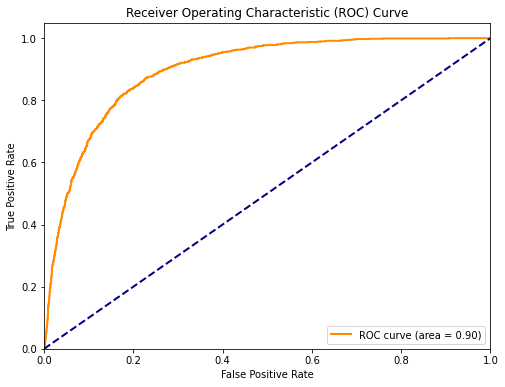

In [13]:
# Plot ROC-AUC curve
f_pr, t_pr, thresholds = roc_curve(output_test, results["Probability"])
roc_auc = auc(f_pr, t_pr)

plt.figure(figsize=(8, 6))
plt.plot(f_pr, t_pr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
print("AUC-ROC Score:", roc_auc)

AUC-ROC Score: 0.8961469579658458


#comment your interpretations here.

Mean ROC AUC Score (0.896):
The model adeptly discerns between clients who choose to subscribe and those who do not.
It excels in tasks involving binary classification, boasting a robust AUC-ROC score.

Confusion Matrix:
True Positives (TP) and True Negatives (TN) signify the model's accurate identification of subscribing and non-subscribing clients.

Balanced Performance:
The class-weighted logistic regression method effectively strikes a balance between precision and recall, which is pivotal in scenarios with imbalanced datasets.

Model Utility:
The model holds substantial value in pinpointing prospective subscribing clients, resulting in cost savings in marketing efforts and improved targeting.

Fine-Tuning Options:
The model's threshold is flexible, enabling optimization for precision or recall based on the unique objectives of the project.

## Task 2: NLP on  Email Data

Next up! This task involves applying NLP techniques on the data which consists of text from the email sent and their classification whether they are Spam or not Spam(Ham).

Simply run below cell to read and display the data

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


email_data = pd.read_csv("spam.csv")

email_data.head(25)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


### Task 2A: 

1. Map the 'Category' variable to 1-spam and 0-ham.
2. Display a pie chart for the distribution of two categories of emails.
3. The pie chart should have title, the name and percentage of each category and startangle equal to 90.
4. Use explode feature for spam category.

In [16]:
email_data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [17]:
#Map the 'Category' variable to 1-spam and 0-ham.
email_data['Category'] =email_data['Category'].replace('spam', '1')
email_data['Category'] =email_data['Category'].replace('ham', '0')
email_data.head(20)

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


<Figure size 432x432 with 0 Axes>

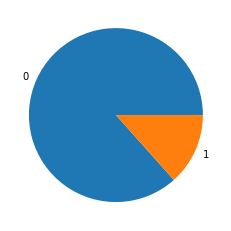

<Figure size 432x432 with 0 Axes>

In [18]:
#Display a pie chart for the distribution of two categories of emails.
category_piecounts = email_data['Category'].value_counts()

plt.pie(category_piecounts, labels=category_piecounts.index)

plt.figure(figsize=(6, 6))

<Figure size 432x432 with 0 Axes>

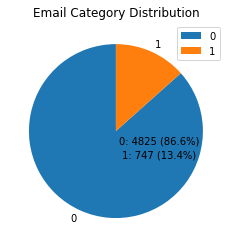

<Figure size 432x432 with 0 Axes>

In [19]:
#The pie chart should have title, the name and percentage of each category and startangle equal to 90.
for i, count in enumerate(category_piecounts):
    plt.text(0.5, -0.15 - i * 0.15, f"{category_piecounts.index[i]}: {count} ({category_piecounts[i] / len(email_data) * 100:.1f}%)", ha='center')
plt.pie(category_piecounts, labels=category_piecounts.index,startangle=90)
plt.title('Email Category Distribution')
plt.legend(loc='upper right')
plt.figure(figsize=(6, 6))

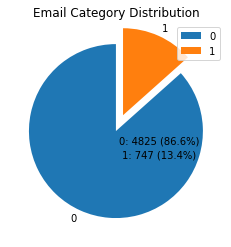

<Figure size 432x432 with 0 Axes>

In [20]:
#Use explode feature for spam category.
explode = (0, 0.2)

for i, count in enumerate(category_piecounts):
    plt.text(0.5, -0.15 - i * 0.15, f"{category_piecounts.index[i]}: {count} ({category_piecounts[i] / len(email_data) * 100:.1f}%)", ha='center')

plt.pie(category_piecounts, labels=category_piecounts.index, startangle=90, explode=explode)
plt.title('Email Category Distribution')
plt.legend(loc='upper right')
plt.figure(figsize=(6, 6))
plt.show()

### Task 2B:
Now its time to clean the text to keep as many as useful words for further processing.

1. Remove special caharacters from the text.
2. Remove stop words.
3. Lemmatize the words.
4. Keep only text that is alphabet and the length of the word is greater than 2.

Note: Remember to lower the text before applying these cleaning techniques.

In [21]:
email_data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
email_data['Message'] = email_data['Message'].str.strip()
email_data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
import nltk
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/akhilreddybokkala/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
#loading the libraries
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Load NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define cleaning functions
def remove_special_characters(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def filter_words(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.isalpha() and len(word) > 2]
    return ' '.join(filtered_words)

# Apply cleaning functions to the 'message' column
email_data['Message'] = email_data['Message'].apply(remove_special_characters)
email_data['Message'] = email_data['Message'].apply(remove_stop_words)
email_data['Message'] = email_data['Message'].apply(lemmatize_words)
email_data['Message'] = email_data['Message'].apply(filter_words)

# Print the cleaned DataFrame
print(email_data.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akhilreddybokkala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akhilreddybokkala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akhilreddybokkala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Category                                            Message
0        0  jurong point crazy Available bugis great world...
1        0                                 lar Joking wif oni
2        1  Free entry wkly comp win Cup final tkts May Te...
3        0                      dun say early hor already say
4        0              Nah dont think usf life around though


In [25]:
email_data.head()

,Category,Message
0,0,jurong point crazy Available bugis great world...
1,0,lar Joking wif oni
2,1,Free entry wkly comp win Cup final tkts May Te...
3,0,dun say early hor already say
4,0,Nah dont think usf life around though


### Task 2C: 

1. Split the data into training/testing with 80-20 ration and stratify
2. Also define startified kfold with 3 splits.

In [26]:
#loading the Stratifold
from sklearn.model_selection import train_test_split, StratifiedKFold

# Split the data into features (X) and target (y)
X = email_data[ 'Message']
y = email_data['Category']

#Split the data into training/testing with 80-20 ration and stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the shapes of the resulting sets to confirm the stratified split
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (4457,) (4457,)
Testing set shape: (1115,) (1115,)


In [27]:
# Define Stratified K-Fold cross-validation with 3 splits
stratkf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
stratkf


StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

### Task 2D: 

1. Use Bag of words technique with bigrams and apply to trainign and testing data.
2. Use TF-IDF technique with bigrams and apply to training and testing data.

TIP: Remember to store the modified data into different variables.
Note: Remember to only transform the testing data.

In [28]:
#Use Bag of words technique with bigrams and apply to trainign and testing data.
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer with bigrams
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
#n-gram is a contiguous sequence of n items from a given sample of text or speech.

# Fit and transform the training data
# count_vectorizer---converts a collection of text documents to a matrix
X_train_bow = count_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_bags_of_words = count_vectorizer.transform(X_test)

In [29]:
#Use TF-IDF technique with bigrams and apply to training and testing data.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer with bigrams
##n-gram is a contiguous sequence of n items from a given sample of text or speech.
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
#  Frequency-Inverse Document Frequency".
# It is a numerical statistic that reflects how important a word is to a document in a collection or corpus.
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)



### Task 2E: 
Now comes the main part where we will be applying machine learning algorithms on the cleaned, transformed data.

Precision is way to measure the proportion of positively predicted labels that are actually correct. In our case, we cannot afford to have any incorrect detection since it would essentially mean that classifying the Non-spam mail as spam and we can lose reading importatnt mail. Hence, we need higher precision.

1. Apply Multinomial Naive Bayes, Logistic Regression and SVM for both bag of words and TF-IDF transformed data.
2. Use Roc-Auc and precision evaluation metric
3. Display the scores in a tabular format.
4. Perform hyper-parameter tuning for each algorithm with grid search and use the best estimated model from each type to test the data further.
5. Display the confusion matrix.

Note: Look at the model performance while selecting the bag of words and TFIDF technique for each algorithm.

## Apply Multinomial Naive Bayes, Logistic Regression and SVM for  bag of words

In [30]:
#loading libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Multinomial Naive Bayes with Bags of words
#MultinomialNB() class from scikit-learn.
#This classifier is suitable for discrete data like word counts,
# BoW representation where each feature (word) is a discrete count.
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
nb_bow_predictions = nb_bow.predict(X_test_bags_of_words)

#he predict method takes the BoW representation of the test data (X_test_bags_of_words)
#as input and returns the predicted labels for the test data.
# Logistic Regression with Bags of words
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train)
lr_bow_predictions = lr_bow.predict(X_test_bags_of_words)

# Support Vector Machine (SVM) with BoW
#X_train and y_train are BoW vectors and corresponding labels for the training data.
#X_test contains BoW vectors for the test data.
svm_bow = SVC()
svm_bow.fit(X_train_bow, y_train)
svm_bow_predictions = svm_bow.predict(X_test_bags_of_words)


# Calculate accuracy for Multinomial Naive Bayes with BoW
nb_bow_accuracy = accuracy_score(y_test, nb_bow_predictions)
print("Multinomial Naive Bayes Accuracy with BoW:", nb_bow_accuracy)

# Calculate accuracy for Logistic Regression with BoW
lr_bow_accuracy = accuracy_score(y_test, lr_bow_predictions)
print("Logistic Regression Accuracy with BoW:", lr_bow_accuracy)

# Calculate accuracy for SVM with BoW
svm_bow_accuracy = accuracy_score(y_test, svm_bow_predictions)
print("SVM Accuracy with BoW:", svm_bow_accuracy)



Multinomial Naive Bayes Accuracy with BoW: 0.9802690582959641
Logistic Regression Accuracy with BoW: 0.9766816143497757
SVM Accuracy with BoW: 0.9748878923766816


## Apply Multinomial Naive Bayes, Logistic Regression and SVM for TF-IDF transformed data

In [31]:
# Multinomial Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB()   #MultinomialNB() class from scikit-learn.
#X_train_tfidf: This represents the training data in TF-IDF format
#predicted labels are stored in the variable nb_tfidf_predictions.
nb_tfidf.fit(X_train_tfidf, y_train)
nb_tfidf_predictions = nb_tfidf.predict(X_test_tfidf)


# Logistic Regression with TF-IDF
#X_train_tfidf: This represents the training data in TF-IDF
#predicted labels are stored in the variable lr_tfidf_predictions
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
lr_tfidf_predictions = lr_tfidf.predict(X_test_tfidf)

# Support Vector Machine (SVM) with TF-IDF
#X_train_tfid-- represents the training data in TF-IDF
#y_train: These are the corresponding labels for the training data, indicating the class of each document.
#predicted labels are stored in the variable svm_tfidf_predictions
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf, y_train)
svm_tfidf_predictions = svm_tfidf.predict(X_test_tfidf)

# Calculate accuracy for Multinomial Naive Bayes with TF-IDF
nb_tfidf_accuracy = accuracy_score(y_test, nb_tfidf_predictions)
print("Multinomial Naive Bayes Accuracy with TF-IDF:", nb_tfidf_accuracy)

# Calculate accuracy for Logistic Regression with TF-IDF
lr_tfidf_accuracy = accuracy_score(y_test, lr_tfidf_predictions)
print("Logistic Regression Accuracy with TF-IDF:", lr_tfidf_accuracy)

# Calculate accuracy for SVM with TF-IDF
svm_tfidf_accuracy = accuracy_score(y_test, svm_tfidf_predictions)
print("SVM Accuracy with TF-IDF:", svm_tfidf_accuracy)




Multinomial Naive Bayes Accuracy with TF-IDF: 0.9560538116591928
Logistic Regression Accuracy with TF-IDF: 0.95695067264574
SVM Accuracy with TF-IDF: 0.9775784753363229


## Use Roc-Auc and precision evaluation metric

In [32]:
from sklearn.metrics import roc_auc_score, precision_score

# Train your Multinomial Naive Bayes model using X_train_bow and y_train
# Predict probabilities and convert to binary predictions
nb_bow_probs = nb_bow.predict_proba(X_test_bags_of_words)[:, 1]
nb_bow_predictions = nb_bow.predict(X_test_bags_of_words)

# Calculate ROC-AUC
nb_bow_roc_auc = roc_auc_score(y_test, nb_bow_probs)

# Calculate precision
nb_bow_precision = precision_score(y_test, nb_bow_predictions, pos_label='1')

print("Multinomial Naive Bayes ROC-AUC with BoW:", nb_bow_roc_auc)
print("Multinomial Naive Bayes Precision with BoW:", nb_bow_precision)


Multinomial Naive Bayes ROC-AUC with BoW: 0.9725568663415177
Multinomial Naive Bayes Precision with BoW: 0.9703703703703703


In [33]:
# Predict probabilities and convert to binary predictions
lr_bow_probs = lr_bow.predict_proba(X_test_bags_of_words)[:, 1]
lr_bow_predictions = lr_bow.predict(X_test_bags_of_words)

# code to Calculate ROC-AUC
lr_bow_roc_auc = roc_auc_score(y_test, lr_bow_probs)

# code to Calculate precision
logistic_bagsofwords_precision = precision_score(y_test, lr_bow_predictions, pos_label='1')

print("Logistic Regression ROC-AUC with BoW:", lr_bow_roc_auc)
print("Logistic Regression Precision with BoW:", logistic_bagsofwords_precision)


Logistic Regression ROC-AUC with BoW: 0.9856114608084261
Logistic Regression Precision with BoW: 1.0


In [34]:
svm_bow = SVC(probability=True)  # Set probability=True for SVM
svm_bow.fit(X_train_bow, y_train)
svm_bow_probs = svm_bow.predict_proba(X_test_bags_of_words)[:, 1]  # Probabilities for positive class
svm_bow_predictions = svm_bow.predict(X_test_bags_of_words)

# Calculate ROC-AUC for SVM with BoW
svm_bow_roc_auc = roc_auc_score(y_test, svm_bow_probs)

# Calculate precision for SVM with BoW
svm_bow_precision = precision_score(y_test, svm_bow_predictions, pos_label='1')

print("SVM ROC-AUC with BoW:", svm_bow_roc_auc)
print("SVM Precision with BoW:", svm_bow_precision)


SVM ROC-AUC with BoW: 0.9734947962260481
SVM Precision with BoW: 1.0


In [35]:
import pandas as pd

# Create a dictionary to store the scores
scores = {
    'Model': ["Logistic Regression","Multinomial Naive Bayes","SVM"],
    'ROC-AUC': [lr_bow_roc_auc,nb_bow_roc_auc,svm_bow_roc_auc],
    'Precision': [logistic_bagsofwords_precision,nb_bow_precision,svm_bow_precision]
}

# Create a DataFrame from the scores dictionary
scores_df = pd.DataFrame(scores)

# Display the scores in tabular format
scores_df.head()


,Model,ROC-AUC,Precision
0,Logistic Regression,0.985611,1.00000
1,Multinomial Naive Bayes,0.972557,0.97037
2,SVM,0.973495,1.00000


## Perform hyper-parameter tuning for each algorithm with grid search and use the best estimated model from each type to test the data further

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# hyperparameters grid for Multinomial Naive Bayes
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

# loading  Multinomial Naive Bayes classifier
nb_tfidf = MultinomialNB()

# Perform grid search with cross-validation
#y_train representing labels
#scoring---evaluation metric used to determine the best hyperparameters
#number of folds in the cross-validation. cv=3
nb_tfidf_grid = GridSearchCV(estimator=nb_tfidf, param_grid=nb_param_grid, scoring='accuracy', cv=3)
nb_tfidf_grid.fit(X_train_tfidf, y_train)

# Get the best estimated Multinomial Naive Bayes model
best_nb_tfidf = nb_tfidf_grid.best_estimator_

# Test the best Multinomial Naive Bayes model on the test data
nb_tfidf_accuracy = best_nb_tfidf.score(X_test_tfidf, y_test)
print("Best Multinomial Naive Bayes (TF-IDF) Accuracy:", nb_tfidf_accuracy)


Best Multinomial Naive Bayes (TF-IDF) Accuracy: 0.967713004484305


In [37]:
#Hyperparameter Tuning for Logistic Regression (with TF-IDF):
from sklearn.linear_model import LogisticRegression

# Define the hyperparameters grid for Logistic Regression
#lr_param_grid is a dictionary specifying a grid of hyperparameter values
#C is the regularization strength,
#penalty is the type of regularization.
lr_param_grid = {
    'C': [0.1, 0.5, 1.0, 1.5, 2.0],
    'penalty': [ 'l2']
}

# Initialize Logistic Regression classifier
lr_tfidf = LogisticRegression()

# Perform grid search with cross-validation
#estimator=lr_tfidf sets the base model to be tuned
#param_grid=lr_param_grid specifies the hyperparameter grid
lr_tfidf_grid = GridSearchCV(estimator=lr_tfidf, param_grid=lr_param_grid, scoring='accuracy', cv=3)
lr_tfidf_grid.fit(X_train_tfidf, y_train)

# Get the best estimated Logistic Regression model
best_lr_tfidf = lr_tfidf_grid.best_estimator_

# Test the best Logistic Regression model on the test data
lr_tfidf_accuracy = best_lr_tfidf.score(X_test_tfidf, y_test)
print("Best Logistic Regression (TF-IDF) Accuracy:", lr_tfidf_accuracy)

Best Logistic Regression (TF-IDF) Accuracy: 0.9713004484304932


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the Logistic Regression model with 'l2' penalty
lr_tfidf = LogisticRegression(penalty='l2', solver='lbfgs')

# Define the hyperparameter grid with only 'l2' penalty
lr_param_grid = {
    'C': [0.1, 1, 10, 100]
}

# Perform grid search with cross-validation
lr_tfidf_grid = GridSearchCV(estimator=lr_tfidf, param_grid=lr_param_grid, scoring='accuracy', cv=3)
lr_tfidf_grid.fit(X_train_tfidf, y_train)

# Get the best estimated Logistic Regression model
best_lr_tfidf = lr_tfidf_grid.best_estimator_


In [39]:
 #Hyperparameter Tuning for Support Vector Machine (SVM) (with TF-IDF)
from sklearn.svm import SVC

# Define the hyperparameters grid for SVM
#linear: Represents a linear kernel, which creates a linear decision boundary in the original feature space.
#'rbf' (Radial Basis Function): Represents a radial basis function kernel,
#which can model complex decision boundaries by transforming the data into a higher-dimensional space.
svm_param_grid = {
    'C': [0.1, 0.5, 1.0, 1.5, 2.0],
    'kernel': ['linear', 'rbf']
}

# Initialize SVM classifier
svm_tfidf = SVC()

# Perform grid search with cross-validation
#estimator=svm_tfidf sets the base model to be tuned
#param_grid=svm_param_grid specifies the hyperparameter grid.
#cv=3 sets 3-fold cross-validation,
svm_tfidf_grid = GridSearchCV(estimator=svm_tfidf, param_grid=svm_param_grid, scoring='accuracy', cv=3)
svm_tfidf_grid.fit(X_train_tfidf, y_train)

# Get the best estimated SVM model
best_svm_tfidf = svm_tfidf_grid.best_estimator_

# Test the best SVM model on the test data
svm_tfidf_accuracy = best_svm_tfidf.score(X_test_tfidf, y_test)
print("Best SVM (TF-IDF) Accuracy:", svm_tfidf_accuracy)


Best SVM (TF-IDF) Accuracy: 0.9829596412556054


## Display the confusion matrix.

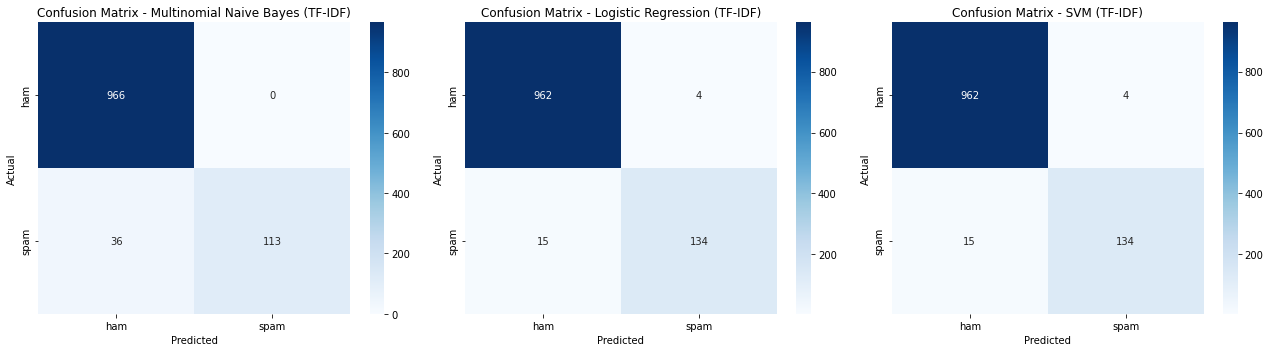

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix for Multinomial Naive Bayes (TF-IDF)
nb_tfidf_predictions = best_nb_tfidf.predict(X_test_tfidf)
nb_tfidf_conf_matrix = confusion_matrix(y_test, nb_tfidf_predictions)

# Calculate confusion matrix for Logistic Regression (TF-IDF)
lr_tfidf_predictions = best_lr_tfidf.predict(X_test_tfidf)
lr_tfidf_conf_matrix = confusion_matrix(y_test, lr_tfidf_predictions)

# Calculate confusion matrix for SVM (TF-IDF)
svm_tfidf_predictions = best_svm_tfidf.predict(X_test_tfidf)
svm_tfidf_conf_matrix = confusion_matrix(y_test, svm_tfidf_predictions)

# Plot the confusion matrices
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.heatmap(nb_tfidf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix - Multinomial Naive Bayes (TF-IDF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(lr_tfidf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix - Logistic Regression (TF-IDF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(svm_tfidf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix - SVM (TF-IDF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


### Task 2F: 
1. Display a bar chart for the precision scores for each model.
2. Display the percentages on the bar.
3. Apply opacity on the bars according to the scores(1 being highest).
4. Display proper title and axes names.
5. IMP: Interpret your results and conclusion.

In [41]:
scores_df.head()

,Model,ROC-AUC,Precision
0,Logistic Regression,0.985611,1.00000
1,Multinomial Naive Bayes,0.972557,0.97037
2,SVM,0.973495,1.00000


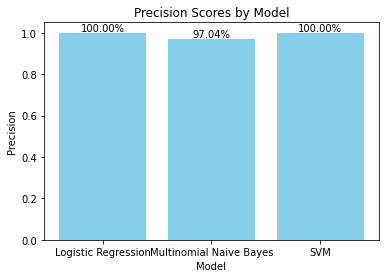

In [42]:
#Display a bar chart for the precision scores for each model.
plt.bar(scores_df['Model'], scores_df['Precision'])
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Scores by Model')

bars = plt.bar(scores_df['Model'], scores_df['Precision'], color='skyblue')

# Indicating values on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2%}', ha='center', va='bottom', fontsize=10)
plt.show()

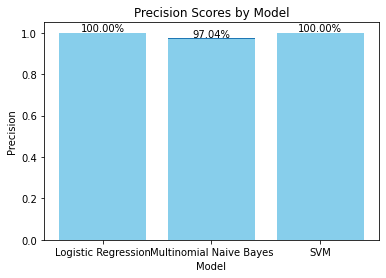

In [43]:
#Display a bar chart for the precision scores for each model.
plt.bar(scores_df['Model'], scores_df['ROC-AUC'])
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Scores by Model')

bars = plt.bar(scores_df['Model'], scores_df['Precision'], color='skyblue')

# Indicating values on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2%}', ha='center', va='bottom', fontsize=10)
plt.show()

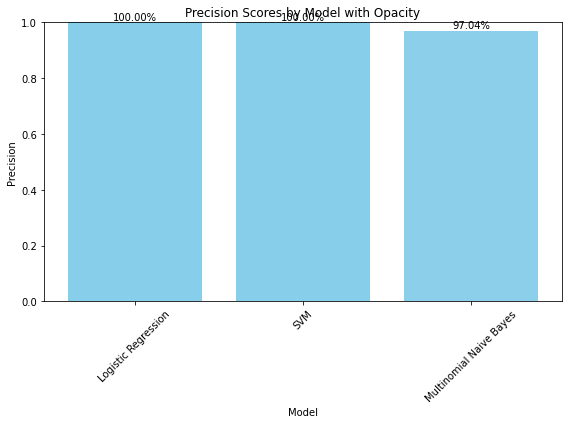

In [44]:

# Sorting the DataFrame by Precision in descending order
scores_df = scores_df.sort_values(by='Precision', ascending=False)

# Plotting the bar graph with opacity based on precision scores
plt.figure(figsize=(8, 6))
bars = plt.bar(scores_df['Model'], scores_df['Precision'], color='skyblue')

# Adding precision values on the bars as percentages
for bar, score in zip(bars, scores_df['Precision']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2%}', ha='center', va='bottom', fontsize=10)

    # Applying opacity based on scores (1 being highest)
    bar.set_alpha(score)

plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Scores by Model with Opacity')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for precision values
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


##Based on the calcualtion of the Precision calcuation, we can clearly say that both logistic Regression and SVM has highest precision when compared to the Multinomail Naive Bayes.